# Mise en place des données

In [1]:
# Standard imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential,  load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, MaxPooling2D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Importing our own modules

import sys

sys.path.insert(0, '/Users/manu/Desktop/ML_projects/DataScientest/DoctorPy') # Your own path

from utils.preprocessing import resize_img, img_zoom, thresh_inf, edge_brightness, adjust_brightness_func, lda_test
from utils.unet_pp import final_pp, build_model
from utils.model_builds import *

In [3]:
df = pd.read_csv('../data/eda_df.csv', index_col=0)

labels_dict = {'COVID-19':0, 'NORMAL':1, 'Viral Pneumonia':2}

X = df['path']
y = [labels_dict[label] for label in df['label']]

X_train, X_, y_train, y_ = train_test_split(X, y,
                                            test_size=0.4,
                                            random_state=27)

X_val, X_test, y_val, y_test = train_test_split(X_, y_,
                                                test_size=0.5,
                                                random_state=27)

In [4]:
# A few callbacks

checkpoint_filepath = 'Checkpoints/Simple'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  restore_best_weights=True)

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  patience=3,
                                                  verbose=2,
                                                  mode='min')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

# Architecture simple

## Sans preprocessing

### Entraînement

In [107]:
# loading data
dataset_train_raw = batch_generator(X_train, y_train)
dataset_val_raw = batch_generator(X_val, y_val)

Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!
Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!


In [5]:
# model building
model = build_simple_model()

In [20]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 252, 252, 32)      832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 16)      4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [21]:
# training the model
history = model.fit(dataset_train_raw,
                    epochs=10,
                    validation_data=dataset_val_raw,
                    callbacks=[lr_plateau]) # You can add any other callback here

Epoch 1/10
72/72 [==============================] - 1s 16ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2574 - val_accuracy: 0.9426
Epoch 2/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2564 - val_accuracy: 0.9426
Epoch 3/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2567 - val_accuracy: 0.9426
Epoch 4/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.2558 - val_accuracy: 0.9426
Epoch 5/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2563 - val_accuracy: 0.9426
Epoch 6/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2566 - val_accuracy: 0.9426
Epoch 7/10
72/72 [==============================] - 1s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9426

Epoch 00007:

In [22]:
# save weights:
# model.save_weights("../models/saved_weights/simple_weight_no_pp.h5")

In [23]:
# save model:
# model.save("../models/saved_models/simple_model_no_pp.h5")

In [6]:
# load model:
model.load_weights('../models/saved_weights/simple_weight_no_pp.h5')

In [7]:
conf_mat(X_test, y_test, model)    

Predictions,COVID-19,NORMAL,Viral Pneumonia
Actual labels,,,
COVID-19,231,4,2
NORMAL,4,259,3
Viral Pneumonia,1,16,246


### Interprétabilité

In [7]:
i = np.random.randint(len(X_test))

img = simple_preprocessing(X_test.iloc[i]).reshape(1, 256, 256, 1)

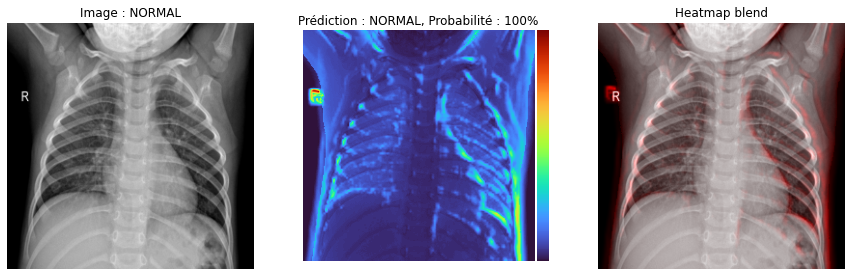

In [9]:
fig = plot_gradcam(model, img, y_true=y_test[i])

Il semble que le modèle ne se base pas ou très peu sur les poumons en eux-mêmes.

## Preprocessing zoom

### Entraînement

In [26]:
# loading data
dataset_train_zoom = batch_generator(X_train, y_train, preprocess='zoom')
dataset_val_zoom = batch_generator(X_val, y_val, preprocess='zoom')

Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!
Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!


In [4]:
# model building
model = build_simple_model()

In [28]:
# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 252, 252, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 16)      4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [29]:
# training the model
history = model.fit(dataset_train_zoom,
                    epochs=10,
                    validation_data=dataset_val_zoom,
                    callbacks=[lr_plateau]) # You can add any other callback here

Epoch 1/10
72/72 [==============================] - 17s 29ms/step - loss: 24.7453 - accuracy: 0.6587 - val_loss: 0.2958 - val_accuracy: 0.8838
Epoch 2/10
72/72 [==============================] - 2s 26ms/step - loss: 0.2491 - accuracy: 0.9134 - val_loss: 0.2660 - val_accuracy: 0.8903
Epoch 3/10
72/72 [==============================] - 2s 26ms/step - loss: 0.1580 - accuracy: 0.9499 - val_loss: 0.1902 - val_accuracy: 0.9347
Epoch 4/10
72/72 [==============================] - 2s 26ms/step - loss: 0.1116 - accuracy: 0.9678 - val_loss: 0.1973 - val_accuracy: 0.9347
Epoch 5/10
72/72 [==============================] - 2s 26ms/step - loss: 0.0932 - accuracy: 0.9704 - val_loss: 0.3665 - val_accuracy: 0.8838
Epoch 6/10
72/72 [==============================] - 2s 26ms/step - loss: 0.0980 - accuracy: 0.9591 - val_loss: 0.2895 - val_accuracy: 0.9138

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.000000142492354e-05.
Epoch 7/10
72/72 [==============================] - 2s 26ms/step - loss

In [30]:
# save weights:
# model.save_weights("../models/saved_weights/simple_weight_zoom_pp.h5")

In [31]:
# save model:
# model.save("../models/saved_models/simple_model_zoom_pp.h5")

In [10]:
# load model:
model.load_weights('../models/saved_weights/simple_weight_zoom_pp.h5')

In [11]:
conf_mat(X_test, y_test, model, zoom_preprocessing)

Predictions,COVID-19,NORMAL,Viral Pneumonia
Actual labels,,,
COVID-19,229,3,5
NORMAL,3,254,9
Viral Pneumonia,4,16,243


### Interpretabilité

In [17]:
i = np.random.randint(len(X_test))

img = zoom_preprocessing(X_test.iloc[i]).reshape(1, 256, 256, 1)

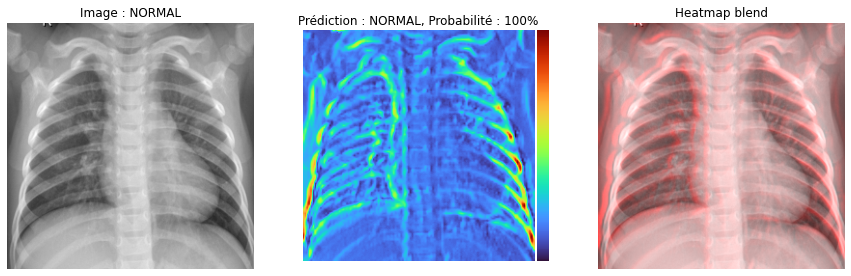

In [18]:
fig = plot_gradcam(model, img, y_true=y_test[i])

Il semble que le modèle soit principalement basé sur les os et les côtes.

## Preprocessing zoom + brightness

### Entraînement

In [34]:
# loading data
dataset_train_brght = batch_generator(X_train, y_train, preprocess='brght')
dataset_val_brght = batch_generator(X_val, y_val, preprocess='brght')

Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!
Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!


In [30]:
# model building
model = build_simple_model()

In [36]:
# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 252, 252, 32)      832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 16)      4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [37]:
# training the model
history = model.fit(dataset_train_brght,
                    epochs=10,
                    validation_data=dataset_val_brght,
                    callbacks=[lr_plateau]) # You can add any other callback here

Epoch 1/10
72/72 [==============================] - 3s 40ms/step - loss: 13.6133 - accuracy: 0.6757 - val_loss: 0.4269 - val_accuracy: 0.8342
Epoch 2/10
72/72 [==============================] - 3s 39ms/step - loss: 0.2336 - accuracy: 0.9203 - val_loss: 0.2771 - val_accuracy: 0.9021
Epoch 3/10
72/72 [==============================] - 3s 39ms/step - loss: 0.0975 - accuracy: 0.9713 - val_loss: 0.2597 - val_accuracy: 0.9191
Epoch 4/10
72/72 [==============================] - 3s 39ms/step - loss: 0.1041 - accuracy: 0.9617 - val_loss: 0.3260 - val_accuracy: 0.9021
Epoch 5/10
72/72 [==============================] - 3s 39ms/step - loss: 0.0628 - accuracy: 0.9782 - val_loss: 0.2674 - val_accuracy: 0.9243
Epoch 6/10
72/72 [==============================] - 3s 39ms/step - loss: 0.0430 - accuracy: 0.9852 - val_loss: 0.3671 - val_accuracy: 0.9112

Epoch 00006: ReduceLROnPlateau reducing learning rate to 3.000000142492354e-05.
Epoch 7/10
72/72 [==============================] - 3s 40ms/step - loss:

In [38]:
# save weights:
# model.save_weights("../models/saved_weights/simple_weight_z_and_b_pp.h5")

In [39]:
# save model:
# model.save("../models/saved_models/simple_model_z_and_b_pp.h5")

In [19]:
# load model:
model.load_weights("../models/saved_weights/simple_weight_z_and_b_pp.h5")

In [16]:
conf_mat(X_test, y_test, model, brght_preprocessing)

Predictions,COVID-19,NORMAL,Viral Pneumonia
Actual labels,,,
COVID-19,225,4,8
NORMAL,2,252,12
Viral Pneumonia,3,18,242


### Interpretabilité

In [24]:
i = np.random.randint(len(X_test))

img = brght_preprocessing(X_test.iloc[i]).reshape(1, 256, 256, 1)

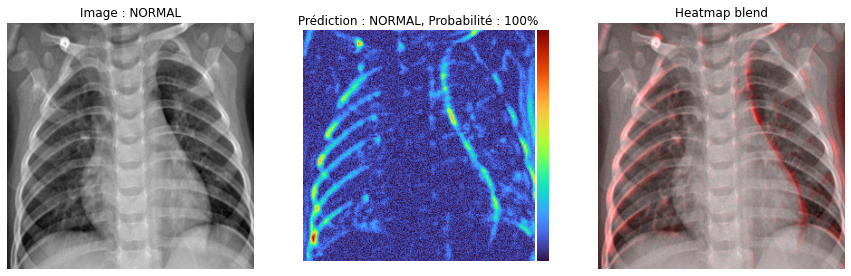

In [25]:
fig = plot_gradcam(model, img, y_true=y_test[i])

Le modèle ne semble toujours pas s'intéresser aux poumons. Nous allons donc tester une architecture plus complexe.

# Architecture VGG

## Sans preprocessing

### Entraînement

In [42]:
# loading data
dataset_train_raw = batch_generator(X_train, y_train)
dataset_val_raw = batch_generator(X_val, y_val)

Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!
Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!


In [26]:
# model building
model = build_vgg()

In [44]:
# model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 256)      

In [45]:
# training the model
history = model.fit(dataset_train_raw,
                    epochs=10,
                    validation_data=dataset_val_raw,
                    callbacks=[lr_plateau]) # You can add any other callback here

Epoch 1/10
72/72 [==============================] - 21s 243ms/step - loss: 1.0133 - accuracy: 0.5921 - val_loss: 0.6405 - val_accuracy: 0.6175
Epoch 2/10
72/72 [==============================] - 12s 173ms/step - loss: 0.4160 - accuracy: 0.8463 - val_loss: 0.2246 - val_accuracy: 0.9217
Epoch 3/10
72/72 [==============================] - 12s 173ms/step - loss: 0.2236 - accuracy: 0.9242 - val_loss: 0.1782 - val_accuracy: 0.9465
Epoch 4/10
72/72 [==============================] - 12s 173ms/step - loss: 0.1706 - accuracy: 0.9334 - val_loss: 0.1716 - val_accuracy: 0.9399
Epoch 5/10
72/72 [==============================] - 12s 173ms/step - loss: 0.1549 - accuracy: 0.9456 - val_loss: 0.1719 - val_accuracy: 0.9399
Epoch 6/10
72/72 [==============================] - 12s 173ms/step - loss: 0.1341 - accuracy: 0.9504 - val_loss: 0.1844 - val_accuracy: 0.9439
Epoch 7/10
72/72 [==============================] - 12s 173ms/step - loss: 0.1579 - accuracy: 0.9469 - val_loss: 0.1944 - val_accuracy: 0.9360

In [46]:
# save weights:
# model.save_weights("../models/saved_weights/VGG_weight_no_pp.h5")

In [47]:
# save model:
# model.save("../models/saved_models/VGG_model_no_pp.h5")

In [27]:
# load weights:
model.load_weights("../models/saved_weights/VGG_weight_no_pp.h5")

In [22]:
conf_mat(X_test, y_test, model)

Predictions,COVID-19,NORMAL,Viral Pneumonia
Actual labels,,,
COVID-19,233,2,2
NORMAL,1,254,11
Viral Pneumonia,5,5,253


### Interpretabilité

In [32]:
i = np.random.randint(len(X_test))

img = simple_preprocessing(X_test.iloc[i]).reshape(1, 256, 256, 1)

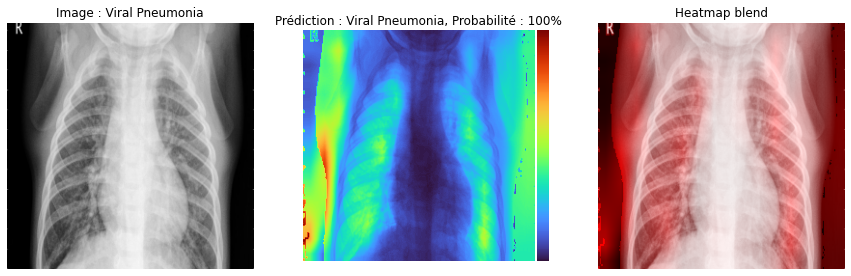

In [33]:
fig = plot_gradcam(model, img, y_true=y_test[i], alpha=0.7)

Le modèle semble accorder un tout petit peu plus d'importance aux poumons mais cela reste léger.

## Preprocessing zoom

### Entraînement

In [50]:
# loading data
dataset_train_zoom = batch_generator(X_train, y_train, preprocess='zoom')
dataset_val_zoom = batch_generator(X_val, y_val, preprocess='zoom')

Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!
Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!


In [54]:
# model building
model = build_vgg()

In [55]:
# model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 256)      

In [45]:
# training the model
history = model.fit(dataset_train_zoom,
                    epochs=10,
                    validation_data=dataset_val_zoom,
                    callbacks=[lr_plateau]) # You can add any other callback here

Epoch 1/10
72/72 [==============================] - 33s 385ms/step - loss: 2.0273 - accuracy: 0.3731 - val_loss: 1.0627 - val_accuracy: 0.3577
Epoch 2/10
72/72 [==============================] - 21s 289ms/step - loss: 1.2091 - accuracy: 0.4236 - val_loss: 1.1056 - val_accuracy: 0.3577
Epoch 3/10
72/72 [==============================] - 21s 289ms/step - loss: 1.0781 - accuracy: 0.4375 - val_loss: 1.1502 - val_accuracy: 0.3329
Epoch 4/10
72/72 [==============================] - 21s 289ms/step - loss: 1.1081 - accuracy: 0.4314 - val_loss: 1.0924 - val_accuracy: 0.3381

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.000000142492354e-05.
Epoch 5/10
72/72 [==============================] - 21s 288ms/step - loss: 0.6497 - accuracy: 0.7231 - val_loss: 0.3731 - val_accuracy: 0.8642
Epoch 6/10
72/72 [==============================] - 21s 289ms/step - loss: 0.4031 - accuracy: 0.8433 - val_loss: 0.3036 - val_accuracy: 0.8851
Epoch 7/10
72/72 [==============================] - 21s 289ms

In [57]:
# save weights:
# model.save_weights("../models/saved_weights/VGG_weight_zoom_pp.h5")

In [58]:
# save model:
# model.save("../models/saved_models/VGG_model_zoom_pp.h5")

In [34]:
# load weights:
model.load_weights("../models/saved_weights/VGG_weight_zoom_pp.h5")

In [27]:
conf_mat(X_test, y_test, model, zoom_preprocessing)

Predictions,COVID-19,NORMAL,Viral Pneumonia
Actual labels,,,
COVID-19,223,3,11
NORMAL,4,229,33
Viral Pneumonia,4,8,251


### Interpretabilité

In [37]:
i = np.random.randint(len(X_test))

img = zoom_preprocessing(X_test.iloc[i]).reshape(1, 256, 256, 1)

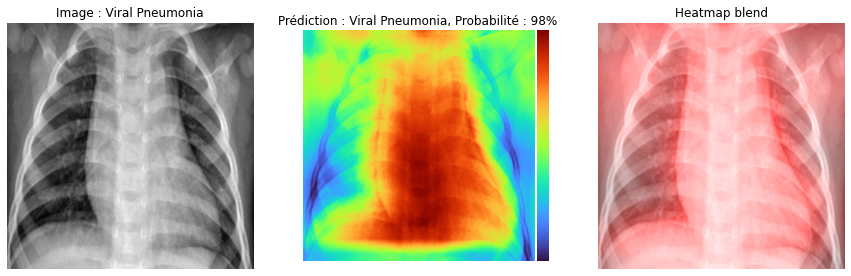

In [38]:
fig = plot_gradcam(model, img, y_true=y_test[i], alpha=0.7)

Comme le modèle précédent, il semble y avoir un peu plus d'intérêt pour les poumons mais cette fois ci, c'est la zone autour de la colonne vertébrale qui semble attirer le plus d'attention.

## Preprocessing zoom + brightness

### Entraînement

In [61]:
# loading data
dataset_train_brght = batch_generator(X_train, y_train, preprocess='brght')
dataset_val_brght = batch_generator(X_val, y_val, preprocess='brght')

Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!
Preprocessing the images...
Creating the dataset...
Resizing the images...
Done!


In [4]:
# model building
model = build_vgg()

In [63]:
# model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 64, 256)      

In [53]:
# training the model
history = model.fit(dataset_train_brght,
                    epochs=10,
                    validation_data=dataset_val_brght,
                    callbacks=[lr_plateau]) # You can add any other callback here

Epoch 1/10
72/72 [==============================] - 23s 311ms/step - loss: 1.3688 - accuracy: 0.4075 - val_loss: 1.0950 - val_accuracy: 0.3329
Epoch 2/10
72/72 [==============================] - 22s 307ms/step - loss: 0.8140 - accuracy: 0.5929 - val_loss: 0.4467 - val_accuracy: 0.8290
Epoch 3/10
72/72 [==============================] - 22s 306ms/step - loss: 0.3871 - accuracy: 0.8637 - val_loss: 0.2629 - val_accuracy: 0.8995
Epoch 4/10
72/72 [==============================] - 22s 306ms/step - loss: 0.2620 - accuracy: 0.9068 - val_loss: 0.2462 - val_accuracy: 0.9060
Epoch 5/10
72/72 [==============================] - 22s 307ms/step - loss: 0.2242 - accuracy: 0.9229 - val_loss: 0.2348 - val_accuracy: 0.9086
Epoch 6/10
72/72 [==============================] - 22s 306ms/step - loss: 0.2023 - accuracy: 0.9238 - val_loss: 0.2861 - val_accuracy: 0.9021
Epoch 7/10
72/72 [==============================] - 22s 306ms/step - loss: 0.1854 - accuracy: 0.9295 - val_loss: 0.3755 - val_accuracy: 0.8668

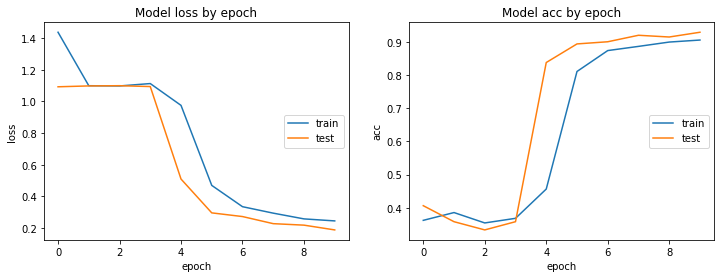

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [65]:
# save weights:
# model.save_weights("../models/saved_weights/VGG_weight_z_and_b_pp.h5")

In [66]:
# save model:
# model.save("../models/saved_models/VGG_model_z_and_b_pp.h5")

In [39]:
# load weights:
model.load_weights("../models/saved_weights/VGG_weight_z_and_b_pp.h5")

In [35]:
conf_mat(X_test, y_test, model, brght_preprocessing)

Predictions,COVID-19,NORMAL,Viral Pneumonia
Actual labels,,,
COVID-19,231,1,5
NORMAL,2,257,7
Viral Pneumonia,4,12,247


### Interpretabilité

In [42]:
i = np.random.randint(len(X_test))

img = brght_preprocessing(X_test.iloc[i]).reshape(1, 256, 256, 1)

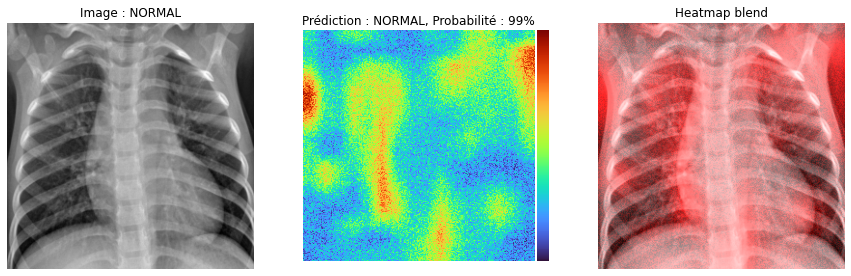

In [43]:
fig = plot_gradcam(model, img, y_true=y_test[i], alpha=0.7)

Ce modèle semble légèrement meilleur que les précédents, bien qu'il ne semble toujours pas regarder réellement l'intérieur des poumons.

# Jeu de données supplémentaire

In [61]:
import os

covid_path_sup = '../data/SUP/COVID/'
covid_files_sup = [covid_path_sup + file for file in os.listdir(covid_path_sup) if file[-3:] == 'png']

normal_path_sup = '../data/SUP/Normal/'
normal_files_sup = [normal_path_sup + file for file in os.listdir(normal_path_sup) if file[-3:] == 'png']

vp_path_sup = '../data/SUP/Viral Pneumonia/'
vp_files_sup = [vp_path_sup + file for file in os.listdir(vp_path_sup) if file[-3:] == 'png']

In [62]:
covid_sup = pd.DataFrame()
covid_sup['path'] = covid_files_sup
covid_sup['label'] = 0

normal_sup = pd.DataFrame()
normal_sup['path'] = normal_files_sup
normal_sup['label'] = 1

vp_sup = pd.DataFrame()
vp_sup['path'] = vp_files_sup
vp_sup['label'] = 2

data_sup = pd.concat([covid_sup, normal_sup, vp_sup])

X = data_sup['path']
y = data_sup['label']

cm = conf_mat(X, y, model, brght_preprocessing)
cm

Predictions,COVID-19,NORMAL,Viral Pneumonia
Actual labels,,,
COVID-19,3469,11,136
NORMAL,8596,1434,162
Viral Pneumonia,14,62,1269


Les prédictions ne sont pas satisfaisantes. La classe `Viral Pneumonia` est probablement la même que dans notre jeu de données initiales (même nombre d'images). On remarque en revanche que le modèle a une forte tendance à classifier les images `NORMAL` jamais vues (certaines sont probablement déjà dans l'ensemble d'entraînement, mais il y a ici 10 000 images de cette classe contre environ 700 dans le jeu d'entraînement).